<a href="https://colab.research.google.com/github/Mauricio-Sousa-Araujo/Aprendizado_Estatistico/blob/master/end_to_end_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##<h1><b>Introdução</b></h1>

Esse Colab tem como objetivo exemplicar um projeto de Machine Learning(ML) end to end mostrando os frequentes problemas que nos deparamos ao analisar um dataset. O método aplicado de ML será simples (Regressão linear), mas tão importante quanto o método usado, é o caminho que precisamos passar para colocarmos os dados de fato em um algoritmo. Exploraremos o dataset [California Housing Prices](https://www.kaggle.com/camnugent/california-housing-prices)(1990). Você pode utilizá-lo como um tool para seus projetos mais avançados.
Ele está dividido da seguinte forma:
1.   Get Data
2.   Conhecendo um pouco os dados
3.   Criando os conjuntos de Test, Training e Validation.
4.   Preparando os dados algoritmos de Machine Learning 
  1.   Lidando com variáveis do tipo string
5.   Feature Scaling
6.   Trabalhando com o primeiro modelo: Regressão Linear
7.   Motivação para a existência do conjunto de validação
8.   Organizando o código





In [211]:
#Bibliotecas usadas
import pandas as pd                 #Para trabalhar com DataFrame
import numpy as np                  #Para trabalhar com matrizes
import matplotlib.pyplot as plt     #Para plotagem dos dados
import sklearn                      #Para os algoritmos de Machine Learning
from urllib.request import urlopen  #Para leitura de dados pelo URL(dataset presente no GitHub)
import os                           #Para trabalhar com diretórios



##<h1><b>1. Get Data </b></h1>

Download e leitura dos dados 

In [212]:
URL = 'https://github.com/Mauricio-Sousa-Araujo/Aprendizado_Estatistico/blob/master/housing.zip?raw=true'
# open and save the zip file onto computer
url = urlopen(URL)
output = open('housing.zip', 'wb')  # note the flag:  "wb"        
output.write(url.read())
output.close()
# read the zip file as a pandas dataframe
data = pd.read_csv('housing.zip')   # pandas version 0.18.1 takes zip files       
# if keeping on disk the zip file is not wanted, then:
os.remove('housing.zip')            # remove the copy of the zipfile on disk
data.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


Vemos abaixo que o dataset possui 10 colunas(features) e um total de 20640 instâncias das quais 9 são do tipo float64 e uma é do tipo object(string nesse caso). Note também que o atributo total_bedrooms possui 20640-20433=207 instâncias não preenchidas(null). Chamando a função descripe, conseguimos mais informações sobre o data, como desvio padrão, média, min, max etc.


In [213]:
print("Data info:")
data.info()
print()
print("Data Descripe:")
data.describe()

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

Data Descripe:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


##<h1><b>2. Conhecendo um pouco os dados</b></h1>



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96e3492fd0>,
      dtype=object)

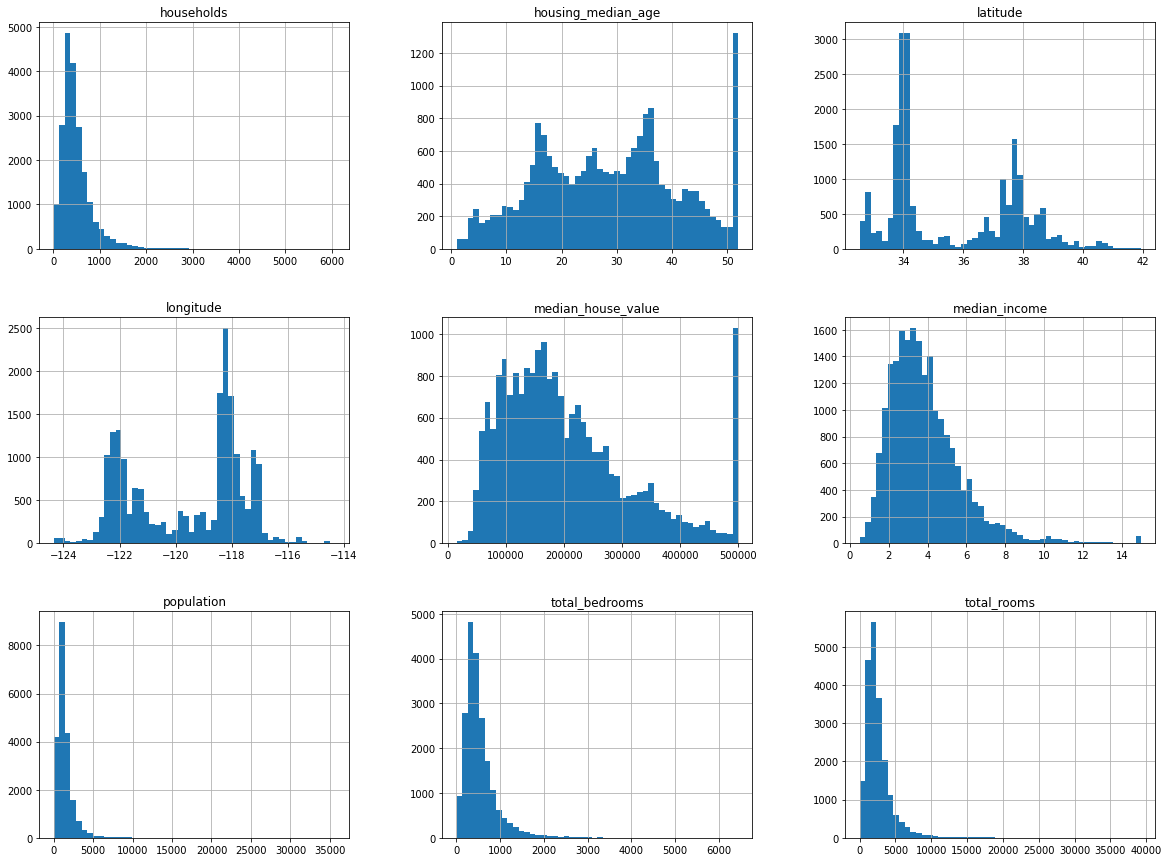

In [214]:
#Histograma para cada feature com 50 intervalos
data.hist(bins=50, figsize=(20,15))

Podemos também plotar longitude por latitude para vermos as regiões

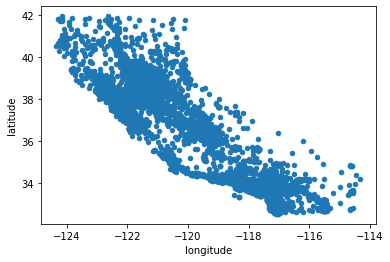

In [215]:
#Mapa da california
data.plot(kind="scatter", x="longitude", y="latitude")

Se baixarmos o grau de opacidade, iremos ver as regiões com alta densidade

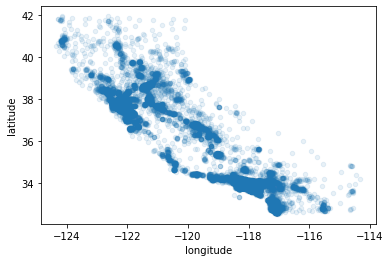

In [216]:
data.plot(kind="scatter", x="longitude", y="latitude",alpha=0.1)

Podemos também ver o valor médio das casas por região com a densidade da população.

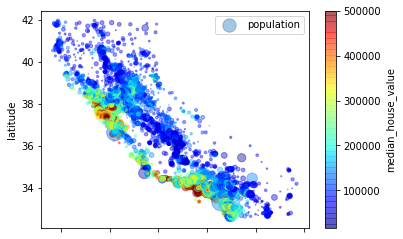

In [217]:
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=data["population"]/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

Uma forma de calcularmos o quanto duas features estão 
relacionadas(por exemplo, se uma tem dependência linear da outra) é utilizar o Pearson's product-moment coefficient.
$$
{\rho _{X,Y}=\operatorname {corr} (X,Y)={\operatorname {cov} (X,Y) \over \sigma _{X}\sigma _{Y}}={\operatorname {E} [(X-\mu _{X})(Y-\mu _{Y})] \over \sigma _{X}\sigma _{Y}}} 
 {={\operatorname {E} (XY)-\operatorname {E} (X)\operatorname {E} (Y) \over {\sqrt {\operatorname {E} (X^{2})-\operatorname {E} (X)^{2}}}\cdot {\sqrt {\operatorname {E} (Y^{2})-\operatorname {E} (Y)^{2}}}}}
$$
Podemos estimar tal coeficiente pela fórmula:
$$
{\ r_{xy}\quad {\overset {\underset {\mathrm {def} }{}}{=}}\quad {\frac {\sum \limits _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{(n-1)s_{x}s_{y}}}={\frac {\sum \limits _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{\sqrt {\sum \limits _{i=1}^{n}(x_{i}-{\bar {x}})^{2}\sum \limits _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}}} 
$$



In [ ]:
data.corr(method="pearson")


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


Podemos notar na tabela acima que total_rooms possui uma relação quase que linear com total_bedrooms(por conta do coeficiente ser aproximadamente 1). Além disso, latitude e longitude possuem o coeficiente próximo de -1(reta com coefiente negativo). O comando utilizado abaixo plota um atributo contra todos os restantes atributos e assim conseguimos ver as relações. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0b579832e8>,
      dtype=object)

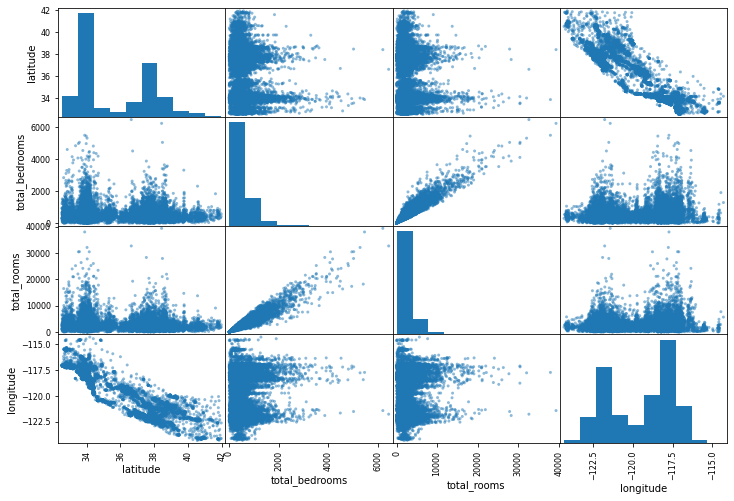

In [ ]:
from pandas.plotting import scatter_matrix
attributes = ["latitude", "total_bedrooms", "total_rooms","longitude"]
scatter_matrix(data[attributes], figsize=(12, 8))

##<h1><b>3. Criando os conjuntos de Test, Training e Validation.`     </b></h1>


In [218]:
def split_data(data,percentual):
  shuffled_indices = np.random.permutation(len(data)) 
  tam = int(len(data) * percentual)
  return data.iloc[shuffled_indices[:tam]] , data.iloc[shuffled_indices[tam:]]

In [219]:
data_train,data_test= split_data(data,0.8)        #80% para treino e 20% para teste
data_train,data_val = split_data(data_train,0.8)  #80% para treino e 20% para validação

print(f'Data Training possui : {data_train.values.shape[0]} instâncias ')
print(f'Data Validation possui : {data_val.values.shape[0]} instâncias ')
print(f'Data Test possui : {data_test.values.shape[0]} instâncias ')

Data Training possui : 13209 instâncias 
Data Validation possui : 3303 instâncias 
Data Test possui : 4128 instâncias 


##<h1><b>4. Preparandos os dados algoritmos de Machine Learning </b></h1>
Como supracitado, existem instâncias que não estão completamente preenchidas, então necessitamos tratar esses casos para que possamos dar como input para Machine Learning Algorithms(em sua grande maioria não trabalham com datasets com lacunas).

Podemos tratar esse problema com as seguintes abordagens:
1.   Livrar-se das instâncias que não estão completamente preenchidas.
2.   Livrar-se de todo a/o feature/atributo.
3.   Definir os valores que faltam para algum valor.No geral, temos dois tipos de abordagens:
  1.   Univariate Imputation: Nessa primeira abordagem, substituimos todos as lacunas de um atributo com simples valor, como a média, mediana ,zero etc.
  2.   Multivariate Imputation : Já nessa abordagem nós utilizamos o próprio dataset(as outras features) para estimar as lacunas.
  
Geralmente a abordagem mais utilizada é a 3, pois nas outras há perca de dados e para alguns problemas, os dados são escassos e valiosos.










In [197]:
#Exemplo simples
# Primeira opção
data_train_dropna=data_train.dropna(subset=["total_bedrooms"]) 
   
# Segunda opção
data_train_feature=data_train.drop("total_bedrooms", axis=1)  

#Terceira opção Univariate Imputation
median = data_train["total_bedrooms"].median()
data_train_fill = data_train["total_bedrooms"].fillna(median) # Terceira opção Univariate Imputation

<h3><b>Univariate e Multivariate Imputation </b></h3>
<h5><b>Observação:</b> Se você é muito iniciante e ainda não conhece nenhum modelo de ML, pule esse tema.</h5>

Podemos empregar essa abordagem utilizando  [Imputation of missing values](https://scikit-learn.org/stable/modules/impute.html) da biblioteca [sklearn](https://scikit-learn.org/stable/). Ela é inspirada no pacote MICE do R. Segue abaixo uma explicação resumida:

To apply MICE, create 5 copies (say) of this simple data set and cycle multiple times through the steps below for each copy:

Step 1: Replace (or impute) the missing values in each variable with temporary "place holder" values derived solely from the non-missing values available for that variable. For example, replace the missing age value with the mean age value observed in the data, replace the missing income values with the mean income value observed in the data, etc.

Step 2 Set back to missing the “place holder” imputations for the age variable only. This way, the current data copy contains missing values for age, but not for income and gender.

Step 3: Regress age on income and gender via a linear regression model (though it is possible to also regress age on only one of these variables); to be able to fit the model to the current data copy, drop all the records where age is missing during the model fitting process. In this model, age is the dependent variable and income and gender are the independent variables.

Step 4 Use the fitted regression model in the previous step to predict the missing age values. (When age will be subsequently used as an independent variable in the regression models for other variables, both the observed values of age and these predicted values will be used.) The article doesn't make it clear that a random component should be added to these predictions.

Step 5: Repeat Steps 2–4 separately for each variable that has missing data, namely income and gender.

Cycling through Steps 1 - 5 once for each of the variables age, income and gender constitutes one cycle. At the end of this cycle, all of the missing values in age, income an gender will have been replaced with predictions from regression models that reflect the relationships observed in the data between these variables.

In [199]:
#Multivariate Imputation MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
data_aux=data_train.drop("ocean_proximity",axis=1)
imp=imp.fit(data_aux)
data_aux=pd.DataFrame(imp.transform(data_aux),columns=data_aux.columns)
data_aux["ocean_proximity"]=data_train["ocean_proximity"].values
data_train_mice=data_aux
data_train_mice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13209 entries, 0 to 13208
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           13209 non-null  float64
 1   latitude            13209 non-null  float64
 2   housing_median_age  13209 non-null  float64
 3   total_rooms         13209 non-null  float64
 4   total_bedrooms      13209 non-null  float64
 5   population          13209 non-null  float64
 6   households          13209 non-null  float64
 7   median_income       13209 non-null  float64
 8   median_house_value  13209 non-null  float64
 9   ocean_proximity     13209 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.0+ MB


Já mostramos anteriormente como fazer Univariate Imputation, mas a biblioteca sklearn também cobre esse tema, como segue abaixo:


In [200]:
#Univariate Imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data_train_fill_mean=data_train.drop("ocean_proximity", axis=1)
columns=data_train_fill_mean.columns
imputer.fit(data_train_fill_mean)
data_train_fill_mean=imputer.transform(data_train_fill_mean)
data_train_fill_mean = pd.DataFrame(data_train_fill_mean, columns=columns)
data_train_fill_mean["ocean_proximity"] = data_train["ocean_proximity"].values
data_train_fill_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13209 entries, 0 to 13208
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           13209 non-null  float64
 1   latitude            13209 non-null  float64
 2   housing_median_age  13209 non-null  float64
 3   total_rooms         13209 non-null  float64
 4   total_bedrooms      13209 non-null  float64
 5   population          13209 non-null  float64
 6   households          13209 non-null  float64
 7   median_income       13209 non-null  float64
 8   median_house_value  13209 non-null  float64
 9   ocean_proximity     13209 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.0+ MB


###<h2><b>4.1 Lidando com variáveis do tipo string(texto)</b></h2>



<h3><b>Label Encoder</b></h3>
Label Encoder consiste basicamente em transformar cada string em um número correspondente. Por exemplo,  suponha que tenhamos os seguintes dados 
data=["cachorro","gato","cachorro","cobra"]. Se aplicassemos tal abordagem, poderiamos ter o seguinte resultado: data_labeled = [1,2,1,3], ou seja, cachorro receberia o número 1, gato o número 2 e cobra 3. Temos que a biblioteca sklear também faz esse trabalho, como abaixo:

In [129]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data_train_fill_mean['ocean_proximity'])
le.transform(data_train_fill_mean['ocean_proximity'])
data_train_fill_mean_le=data_train_fill_mean.copy()
data_train_fill_mean_le['ocean_proximity'] =le.transform(data_train_fill_mean_le['ocean_proximity'])
data_train_fill_mean_le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13209 entries, 0 to 13208
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           13209 non-null  float64
 1   latitude            13209 non-null  float64
 2   housing_median_age  13209 non-null  float64
 3   total_rooms         13209 non-null  float64
 4   total_bedrooms      13209 non-null  float64
 5   population          13209 non-null  float64
 6   households          13209 non-null  float64
 7   median_income       13209 non-null  float64
 8   median_house_value  13209 non-null  float64
 9   ocean_proximity     13209 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 1.0 MB


<h3><b>One Hot Encoder</b></h3>
Label Encoder pode incluir novas características indesejadas ao nosso modelo, como uma relação de proporcionalidade entre features que não deveria existir. Já One Hot Encoder tenta contornar esse problema, no entanto, ele acrescenta novas features ao modelo. Se pegarmos o mesmo exemplo data=["cachorro","gato","cachorro","cobra"], poderiamos ter o seguinte resultado:
  data_ohe={ [1,0,0] , [0,1,0] , [1,0,0] , [0,0,1] }
Note que temos 3 categorias(cachorro, gato e cobra) e por isso cada vetor tem dimensão 3.Além disso, note que cachorro equivale a [1,0,0], gato a [0,1,0] e cobra a [0,0,1].

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False )
data_aux=np.resize(data_train["ocean_proximity"].values,(len(data_train["ocean_proximity"]),1))
ohe.fit(data_aux)
data_aux=np.resize(data_train["ocean_proximity"].values,(len(data_train["ocean_proximity"]),1)) #
ohe.transform(data_aux)
data_train_ohe=data_train.drop("ocean_proximity",axis=1)
data_aux=ohe.transform(data_aux)
for i in range(data_aux.shape[1]):
  data_train_ohe[f"ocean_proximity_{i}"]=data_aux[:,i]
data_train_ohe.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_0,ocean_proximity_1,ocean_proximity_2,ocean_proximity_3,ocean_proximity_4
13204,-119.91,36.83,29.0,2205.0,366.0,1072.0,345.0,3.8056,165400.0,0.0,1.0,0.0,0.0,0.0
13205,-120.94,37.59,16.0,3964.0,824.0,2622.0,766.0,2.3152,111300.0,0.0,1.0,0.0,0.0,0.0
13206,-119.53,37.34,26.0,4047.0,702.0,571.0,199.0,2.3482,179500.0,0.0,1.0,0.0,0.0,0.0
13207,-118.35,33.85,34.0,1770.0,291.0,916.0,289.0,5.0000,354200.0,1.0,0.0,0.0,0.0,0.0
13208,-118.24,34.24,31.0,3812.0,595.0,1645.0,591.0,7.5850,380100.0,1.0,0.0,0.0,0.0,0.0


##<h1><b>5. Feature Scaling  </b></h1>

Temos que para <b>Padronizar</b> os dados  aplicamos a fórmula $$x_{changed}=\frac{x-\mu}{\sigma}$$

Já para <b>Normalizar</b> os dados podemos fazer de algumas fórmulas, por exemplo, podemos usar Min-Max:
$$x_{changed}=\frac{x- x_{min}}{x_{max}-x{min}} $$ Para mais informações sobre qual modelo é melhor [aqui](https://medium.com/data-hackers/normalizar-ou-padronizar-as-vari%C3%A1veis-3b619876ccc9). Mas de forma resumida,as duas técnicas tem o mesmo objetivo: transformar todas as variáveis na mesma ordem de grandeza. E a diferença básica é que padronizar as variáveis irá resultar em uma média igual a 0 e um desvio padrão igual a 1. Já normalizar tem como objetivo colocar as variáveis dentro do intervalo de 0 e 1, caso tenha resultado negativo -1 e 1.Na dúvida de qual modelo escolher, teste os dois modelos. Podemos aplicar tais fórmulas facilmente usando a biblioteca sklearn, respectivamente:




In [130]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(data_train_labeled)
data_train_labeled_std = pd.DataFrame( scaler.transform(data_train_labeled), columns=data_train_labeled.columns)
data_train_labeled_std.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13204,0.736339,-0.844543,-0.674985,1.665744,0.935735,0.743632,0.968579,1.940141,1.669785,-0.816962
13205,0.575974,-0.684749,1.231712,-0.059497,-0.069461,-0.400443,-0.043617,0.619889,1.429591,-0.816962
13206,1.297617,-0.933840,-1.628333,-0.749594,-0.876914,-0.900383,-0.936425,0.211408,0.120531,-0.114818
13207,1.563222,-0.872742,-0.357202,-0.022528,-0.238956,-0.826989,-0.684674,-0.059106,2.506185,-0.114818
13208,1.117206,-0.515556,-0.992767,0.194725,0.170656,-0.127592,0.267828,-0.517676,-0.791350,-0.114818


In [ ]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler().fit(data_train_labeled)
pd.DataFrame(scaler.transform(data_train_labeled),columns=data_train_labeled.columns).tail()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13204,0.439439,0.455319,0.54,0.058073,0.073203,0.037426,0.056570,0.227976,0.310104,0.25
13205,0.336336,0.536170,0.28,0.104442,0.143029,0.091692,0.125802,0.125191,0.198558,0.25
13206,0.477477,0.509574,0.48,0.106630,0.124429,0.019886,0.032560,0.127467,0.339176,0.25
13207,0.595596,0.138298,0.64,0.046606,0.061768,0.031964,0.047361,0.310347,0.699381,0.00
13208,0.606607,0.179787,0.58,0.100435,0.108116,0.057487,0.097024,0.488621,0.752782,0.00



##<h1><b>6. Trabalhando com o primeiro modelo: Regressão Linear </b></h1>




De forma simplificada, temos que a ideia da regressão linear é reduzir o Mean  Square  Error(MSE). Essa equação mede o quão bom o nosso modelo se ajusta aos dados.
$$
MSE(\theta)= \frac{\sum^{m}_{i=1}[(\sum^{n}_{j=0}\theta_{j}x^{(i)}_{j})-y^{(i)}]^2}{m}
$$, onde $\theta_js$ são os parâmetros que serão ajustados para o modelo, $x_j^{(i)}$ é a entrada do modelo representando a j-ésima feature e a i-ésima instância, $y^{(i)}$ representa a variável que estamos tentando predizer. Além disso, $x_0^{(i)}$ é sempre igual a 1  para que bias term($\theta_0$) esteja sempre presente. Para acharmos o mínimo dessa função, podemos derivar em relação da cada $\theta$ e igualar a zero para achar o ponto mínimo, então:
$$
\frac{\partial MSE(\theta)}{\partial\theta_k}=\frac{\sum_{i=1}^{m}2x_k^{(i)}[(\sum^{n}_{j=0}\theta_{j}x^{(i)}_{j})-y^{(i)}]}{m} = \frac{2\sum_{i=1}^{m}x_k^{(i)}\sum_{j=0}^{n}\theta_jx^{(i)}_j-2\sum_{i=1}^m x_{k}^{(i)}y^{(i)}}{m}=0
$$
Portanto,
$$
\sum_{i=1}^{m}x_k^{(i)}\sum_{j=0}^{n}\theta_jx^{(i)}_j-\sum_{i=1}^m x_{k}^{(i)}y^{(i)}=0
$$
Repara que temos n+1 incógnitas($\theta s$) e n+1 equações, podemos recrever tais equações em notação matricial
$$
X^TX \theta =X^{T}Y
$$
então:
$$\theta=((X^TX))^{-1}X^TY$$
 Onde X representa nossa matriz de entrada com a cada coluna representando uma feature e cada linha representando uma instância, Y(nosso Target) uma matriz com 1 coluna e cada linha representando uma instância e $\theta$ nosso hiperparâmetro de uma coluna e n linhas. 
 Tal equação é mais conhecida como a equação normal e com auxílio de bibliotecas o problema fica facilmente resolvível, como abaixo:

In [137]:
n_rows=len(data_train_labeled_std)
X= data_train_labeled_std.drop("median_income",axis=1).values
X =np.column_stack( [np.ones(n_rows),  X])
Y=np.resize( data_train_labeled_std["median_income"].values,(n_rows,1) )
    
def fit(X,Y):
  return np.dot( np.dot( np.linalg.inv( np.dot( X.T,X ) ), X.T) ,Y) #Equação

In [138]:
Theta=fit(X,Y)
Theta

array([[-1.78534216e-16],
       [ 1.95863431e-02],
       [ 7.04257718e-03],
       [-1.39975741e-01],
       [ 1.04471604e+00],
       [-1.19048851e+00],
       [-3.78488997e-03],
       [ 1.39127480e-01],
       [ 6.23815789e-01],
       [-4.80946817e-02]])

Também podemos utilizar a biblioteca sklearn para tal tarefa




In [136]:
from sklearn.linear_model import LinearRegression
n_rows=len(data_train_labeled)
X= data_train_labeled_std.drop("median_income",axis=1).values
Y=np.resize( data_train_labeled_std["median_income"].values,(n_rows,1) )
reg = LinearRegression()
reg.fit(X,Y)
Thetas= np.hstack((reg.intercept_,reg.coef_[0]))
np.resize( Thetas,(10,1) )


array([[-1.86889520e-16],
       [ 1.95863431e-02],
       [ 7.04257718e-03],
       [-1.39975741e-01],
       [ 1.04471604e+00],
       [-1.19048851e+00],
       [-3.78488997e-03],
       [ 1.39127480e-01],
       [ 6.23815789e-01],
       [-4.80946817e-02]])

In [ ]:
reg.score(X,Y)

0.6678321284419713

##<h1><b>7.(Seção em andamento) Motivação para existência do conjunto de validação</b></h1>


<h2>Stochastic Gradient Descent</h2>
Sabemos que se tratando de Machine Learning, os algoritmos possuem um desempenho muito melhor em grandes volumes de dados. Na seção 6 treinamos o modelo utilizando a equação normal para regressão linear, embora seja um método que vá diretamente ao ponto mínimo, sua complexidade para grandes instâncias é alta. Isso se dá pelo fato de ter que calcular uma matriz inversa na fórmula. Os melhores algoritmos de inversão de matrizes possuem uma complexidade que varia de $O(n^{2,4})-O(n^{3})$. Com isso, para instâncias maiores que 100000, já começamos a ter problemas com o tempo de execução. Portanto, é necessário métodos alternativos que minimizem a função de erro de forma mais rápida. Stochastic Gradient Descent(SGD) é uma abordagem que trata justamente esse problema. De forma resumida, ele utiliza a fórmula abaixo a cada iteração:
$$\theta^{(i+1)}_j = \theta^{(i)}_j - n\frac{\partial}{\partial\theta_j}MSE(\theta)$$,
onde n é uma constante chamado pela literatura de learning rate. Intuitivamente, é como se a fórmula a cada iteração visse o quanto devemos tirar ou acrescentar (se a derivada partical for negativa) de um parâmetro para que nossa função de erro seja minimizada. Note que quando a derivada chega próxima de zero(um indício de que estamos em um mínimo local), temos que $\theta_j^{(i+1)}\approx\theta_j^{(i)} $ e o parâmetro estagna ou varia muito pouco. É preciso tomar cuidado sobre a seleção do valor de n, pois para valores muito grandes, a função pode dar saltos e demorar para convergir. Já para valores muito pequenos, também haverá um delay, pois a atualização irá variar os parâmetros em uma quantidade muito pequena. Felizmente, na regressão linear  o mínimo local é igual ao global, e por isso, o método sempre converge para o mínimo global. No entanto, o poder e importância dessa abordagem se reside no fato de que você pode aplicá-la também para funções  não lineares, por exemplo, para funções utilizadas em redes neurais. Abaixo, está a forma de calcular as derivadas partiais. Na primeira fórmula, calculamos para cada $\theta$, na segunda é uma representação matricial para todos os $\theta$s.
$$\frac{\partial{MSE(\theta)}}{\partial \theta_j} = 
\frac{2}{m}\sum_{i=1}^{m}(\theta^T x^{(i)}-y^{(i)})x^{(i)}_j $$
$$\nabla{_\theta}MSE(\theta) = \frac{2}{m}X^T.(X.\theta-Y)  $$
E por fim, a fórmula de atualização final na forma matricial:
$$\theta^{(i+1)}=\theta^{(i)}-n\nabla _\theta MSE(\theta)$$
<b>Importante:</b> SGD não se utiliza de todos os dados de treino. Ele escolhe m dados randomicamente a cada época e atualiza os $\theta$s e é por isso que ele pode ser mais rápido, pois podemos escolher o número de instâncias. O número de épocas e m são hiperparâmetros. O valor de n pode também ser alterado por algumas eurísticas, como a feita no código abaixo.

$$$$

In [182]:
n_rows=len(data_train_labeled_std)
X = data_train_labeled_std.drop("median_income",axis=1).values
X = np.column_stack( [np.ones(n_rows),  X])
Y = np.resize( data_train_labeled_std["median_income"].values,(n_rows,1) )
    
def learning_schedule(epoch,decay,eta):
   return eta * 1/(1 + decay * epoch)

# random initialization
def stochasticGradientDescentRegressionLinear(X,Y,n_epochs,m,eta=0.1):
  n_params,n_rows=X.shape[1], X.shape[0]
  theta = np.random.randn(n_params,1)
  decay = eta / n_epochs
  for epoch in range(n_epochs):
    for i in range(m):
      r=np.random.randint(n_rows)
      X_i = X[r:r+1]
      Y_i = Y[r:r+1]        
      gradients = 2 * X_i.T.dot(X_i.dot(theta) - Y_i)   
      eta = learning_schedule(epoch,decay,eta)        
      theta = theta - eta * gradients
    
  return theta
stochasticGradientDescentRegressionLinear(X,Y,1000,1,0.1)

array([[0.34232386],
       [1.88352607],
       [1.70645599],
       [0.26797509],
       [0.05431502],
       [1.73515493],
       [1.39436497],
       [0.25823992],
       [0.76979734],
       [0.21077413]])

In [187]:
X = data_train_labeled_std.drop("median_income",axis=1).values
Y = np.resize( data_train_labeled_std["median_income"].values,(n_rows,1) )
from sklearn.linear_model import SGDRegressor
clf = SGDRegressor(max_iter=1000, tol=1e-3)
clf.fit(X,Y)
print(clf.intercept_,clf.coef_)

[-0.00925549] [ 6.04248498e-03 -1.00758764e-03 -1.38772924e-01  1.01791025e+00
 -9.77377011e-01  4.61938805e-02 -7.08382560e-02  6.23898059e-01
 -3.48403366e-02]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##<h1><b>8. Organizando o código</b></h1>
Vimos que para chegarmos na fase de treinamento de um modelo, precisamos passar por várias etapas e que algumas partes precisam ser executadas antes de outras, por exemplo, não conseguimos aplicar o modelo de regressão se não tratarmos as lacunas e features do tipo string. Por isso, é muito importante que as células sejam executadas na ordem correta. No entanto, ao invés de sempre ficarmos procurando a célula correta para se executar, podemos fazer tal trabalho de uma forma mais compacta utilizando classes com python.

In [ ]:
import pandas as pd               
import numpy as np                #Para trabalhar com matrizes
import matplotlib.pyplot as plt   #Para plotagem de dos dados
import sklearn 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from urllib.request import urlopen  
import os


def get_data(URL):
  # open and save the zip file onto computer
  url = urlopen(URL)
  output = open('housing.zip', 'wb')    # note the flag:  "wb"        
  output.write(url.read())
  output.close()
  # read the zip file as a pandas dataframe
  data = pd.read_csv('housing.zip')   # pandas version 0.18.1 takes zip files       
  # if keeping on disk the zip file is not wanted, then:
  os.remove('housing.zip')   # remove the copy of the zipfile on disk
  return data

def split_data(data,percentual):
  shuffled_indices = np.random.permutation(len(data))
  tam = int(len(data) * percentual)
  return data.iloc[shuffled_indices[:tam]] , data.iloc[shuffled_indices[tam:]]

def mice_fit(imp,data,exceto=[]):
  df=data.drop(exceto,axis=1)
  return imp.fit(df)

def mice_transform(imp,data,exceto=[]):
  df=data.drop(exceto,axis=1)
  df=pd.DataFrame(imp.transform(df),columns=df.columns)
  for name in exceto:
    df[name]=data[name].values
  return df

def label_encoder_fit(le,df,name_c):
  le.fit(df[name_c])

def label_encoder_transform(le,df,name_c):
  df_c=df.copy()
  df_c[name_c]=le.transform(df_c[name_c])
  return df_c

def standard_scaler_fit(scaler,df):
  scaler.fit(df)

def standard_scaler_transform(scaler,df):
  return pd.DataFrame(scaler.transform(df),columns=df.columns)

def linear_regression_fit(lreg,X,Y):
  lreg.fit(X,Y)

def linear_regression_score(lreg,X,Y):
  return lreg.score(X, Y)


In [ ]:
URL = 'https://github.com/Mauricio-Sousa-Araujo/Aprendizado_Estatistico/blob/master/housing.zip?raw=true'
data=get_data(URL)
data_train,data_test= split_data(data,0.8)        #80% para treino e 20% para teste
data_train,data_val = split_data(data_train,0.8)  #80% para treino e 20% para validação
print(f'Data Training possui : {data_train.values.shape[0]} instâncias ')
print(f'Data Validation possui : {data_val.values.shape[0]} instâncias ')
print(f'Data Test possui : {data_test.values.shape[0]} instâncias ')

#MICE
imp_mice=IterativeImputer(max_iter=10)
imp_mice=mice_fit(imp_mice,data_train,exceto=["ocean_proximity"])
data_train=mice_transform(imp_mice,data_train,exceto=["ocean_proximity"])
data_val=mice_transform(imp_mice,data_val,exceto=["ocean_proximity"])
data_test=mice_transform(imp_mice,data_test,exceto=["ocean_proximity"])


#Label encoder
le = preprocessing.LabelEncoder()
label_encoder_fit(le,data_train,name_c="ocean_proximity")
data_train = label_encoder_transform(le, data_train,name_c="ocean_proximity")
data_val   = label_encoder_transform(le, data_val,name_c="ocean_proximity"  )
data_test  = label_encoder_transform(le, data_test,name_c="ocean_proximity" )

#Padroniza
std=preprocessing.StandardScaler()
standard_scaler_fit(std,data_train)
data_train = standard_scaler_transform(std,data_train)
data_val   = standard_scaler_transform(std,data_val)
data_test  = standard_scaler_transform(std,data_test)

#Aplicando model: Regressão Linear
lreg = LinearRegression()
X_train = data_train.drop(["median_income"],axis=1).values
X_val   = data_val.drop(["median_income"],axis=1).values
X_test  = data_test.drop(["median_income"],axis=1).values

Y_train  = np.resize(data_train["median_income"].values,(len(data_train),1))
Y_val    = np.resize(data_val["median_income"].values,(len(data_val),1))
Y_test   = np.resize(data_test["median_income"].values,(len(data_test),1))

linear_regression_fit(lreg,X_train,Y_train)
print(f'Score Train: {linear_regression_score(lreg,X_train,Y_train)}'  )
print(f'Score Validação: {linear_regression_score(lreg,X_val,Y_val)}'  )
print(f'Score Test: {linear_regression_score(lreg,X_test,Y_test)}')



Data Training possui : 13209 instâncias 
Data Validation possui : 3303 instâncias 
Data Test possui : 4128 instâncias 
Score Train: 0.6667451986006754
Score Validação: 0.656955239930143
Score Test: 0.6500061729370988
